In this notebook, I will be training a genetic algorithm to reproduce a single image. I have never used genetic algorithms before, so I thought I would start with a toy problem. The resources posts I found helpful in learning the theory and implementation of these algorithms are below, but the code is my own.
* [Genetic Algorithms: A Tutorial](http://svitvasad.ac.in/svit/data/mca/cosmos/ga.pdf)
* [Introduction to Genetic Algorithms](https://blog.floydhub.com/introduction-to-genetic-algorithms/)  
* [Introduction to Genetic Algorithm & their application in data science](https://www.analyticsvidhya.com/blog/2017/07/introduction-to-genetic-algorithm/)
* [Reproducing Images using a Genetic Algorithm with Python](https://heartbeat.fritz.ai/reproducing-images-using-a-genetic-algorithm-with-python-91fc701ff84)

# Background  

Genetic Algorithms (GAs) are a subset of Evolutionary Algorithms, which are a subset of Guided Random Search Techniques. They are a very rough approximation of the mechanisms and principles that govern biological reproduction and evolution. They an attractive candidate for many different types of optimization problems because they have been shown to balance exploration -- via the fitness and selection functions -- and exploitation -- through the randomness introduced by mutations and crossover -- quite elegantly, in contrast to other optimization algorithms such as neural networks. In particular, the randomness incorporated into these algorithms allows it to escape local minima. The pseudo-code of a very basic genetic algorithm is written below.
  
## Pseudo-code  
**function** GeneticAlgorithm(n_individuals, n_genes, desired_fitness)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *returns* an individual with fitness >= desired_fitness
  
&nbsp;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; generation = 0    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; population = init_population(n_individuals, n_genes)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; fitness_vals = evaluate_fitness(population)  
&nbsp;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **while** max(fitness_vals) < desired_fitness  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; parents = select(population, fitness_vals)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; children = reproduction(parents)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; children = mutate(children, mutation_rate)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; population = make_next_generation(children, parents)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; fitness_vals = evaluate_fitness(population)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; generation = generation + 1

# Defining the Functions  
Now that the rough structure of a basic GA has been illustrated, and we have loaded in an image we want to reproduce and imported python libraries, we are now ready to define the functions needed for the GA.

### Initializing the Population  
Typically each individual is initialized with random values from some set of numbers. Since we are trying to reproduce an image, we chose random values from the range [0, 255].

In [ ]:
def init_population(n_individuals, n_genes):
    return np.random.rand(n_individuals, n_genes) * 255  # population is an array where each row is an individual

### Fitness Function
Perhaps the most important aspect of a GA is the choice of fitness function. As the mathematician and creator of Error-Correcting Codes Richard Hamming once said, "You get what you measure.", where he was basically highlighting the fact that scientists and engineers need to be greatly aware of the influences our choice of metric will have on our results. Since we are trying to reproduce a single image with our algorithm, we will need some way of measuring the difference between the actual image and each individual's reproduction of the image. Possible methods to compute the similarity between images are Signal-to-Noise Ratio (SNR), Peak SNR (PSNR), Euclidean Distance, L1-Distance, and Structural Similarity Index (SSIM), to name a few. Here we use the SSIM metric based on a number of reasons: 1) its values are interpretable and range from -1 to 1, which makes it easy to determine a threshold for stopping the model, 2) it is based off of visual perception and incorporates different perceptual phenomena such as luminance masking, and 3) captures differences in local parts of the image well because it compares small patches with a sliding window.  

In [ ]:
# goint to scale each individual's values between 0 and 255 each time its fitness is evaluated
def scale(img):
    return (img - np.amin(img)) / (np.amax(img) - np.amin(img) + 1e-6) * 255

In [ ]:
def evaluate_fitness(population, real_img):
    fitness_vals = []
    real_imgh, real_imgw = real_img.shape

    # loop through each individual and get its SSIM value
    for individual in population:
        individual_img = individual.reshape([real_imgh, real_imgw])
        individual_img = scale(individual_img)
        fitness = ssim(real_img, individual_img, win_size=7, data_range=255)
        fitness_vals.append(fitness)

    return fitness_vals

### Parent Selection  
Central to the idea of evolution is the fact that the species with low fitness values (as determined by the environment in actual evolution) do not survive and reproduce. Thus, we must have a heuristic to select which individuals from our population will reproduce after their fitness has been evaluated. Here, perhaps in a naive fashion, we keep half of the individuals with the highest fitness values and discard the rest. There are a number of different ways to do this selection process that have been introduced over the years.

In [ ]:
def select(population, fitness_vals):
    n_inds = population.shape[0]  # number of individuals
    n_discard = n_inds // 2  # lower half of population to discard

    # sort the population based on the corresponding fitness values
    sorted_inds = [ind for _, ind in sorted(zip(fitness_vals, list(range(len(fitness_vals)))), key=lambda pair: pair[0])]

    # return the population with those rows removed
    return np.delete(population, sorted_inds[:n_discard], axis=0)

### Reproduction  
Now that we have selected a number of parents allowed to reproduce, we can allow the remaining parents to reproduce with each other. Here, we select all possible combinations of the remaining parents, which will reproduce by randomly taking 50% of the genes from one parent and the other 50% from the other to create a child.

In [ ]:
def reproduction(parents):
    n_parents, n_genes = parents.shape[0], parents.shape[1]

    # get all combinations of parents
    combinations = [[p1, p2] for p1 in range(n_parents-1, 0, -1) for p2 in range(p1-1, -1, -1)]
    #combinations += [[p1, p2] for p1 in range(n_parents-1) for p2 in range(p1+1, n_parents)]

    # select some of these combinations randomly for reproduction
    comb_sample = list(np.random.choice(len(combinations), size=(n_parents), replace=True))
    combinations = [comb for i, comb in enumerate(combinations) if i in comb_sample]

    # initialize an array to fill the children with
    children = np.zeros(parents.shape)

    for i_comb, comb in enumerate(combinations):
        parent1, parent2 = parents[comb[0], :], parents[comb[1], :]

        # mask each parent's genes randomly with an equal probability
        mask1 = np.float32(np.random.rand(n_genes) > 0.5)
        mask2 = np.float32(mask1 == 0)
        parent1, parent2 = parent1 * mask1, parent2 * mask2

        # make the new child and add it to the children array
        children[i_comb, :] = parent1 + parent2

    return children

### Mutation  
Most mutations in biology are detrimental to the individual who has them. There are a number of mechanisms that allows a cell to detect and fix mutations. However, there are still some that go undetected or that can't be repaired. In the grand scale of evolutionary time, mutations are sometimes helpful by introducing an advantageous trait into the population. Here, we use two different methods of mutation: 1) we add random values taken from the normal distribution to each gene, and 2) we randomly drop out a very small percentage of genes each generation.

In [ ]:
def mutate(children):
    n_children, n_genes = children.shape

    # add random noise mutation
    mutations = np.random.randn(n_children, n_genes) * np.random.randint(0, 32, 1)[0]
    children = children + mutations

    # make the dropped-out ones the minimum value in the individual since they will be scaled later
    min_vals = np.amin(children, 1)
    mutation_map = np.float32(np.random.rand(n_children, n_genes) < 0.9999)
    children *= mutation_map  # zero-out all the ones selected by mutation map
    children += (min_vals * np.float32(mutation_map == 0).transpose()).transpose()

    return children

### Add Children to the Population  
Here we add the children to the population with the remaining parents.

In [ ]:
def make_next_generation(parents, children):
    return np.concatenate((parents, children), 0)

# Setting Up the Program  
  
First, let's import some python libraries and functions we will need.

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import imageio
import matplotlib.pyplot as plt

Now we will load in the image we are trying to reproduce. For this exercise, I have chosen a very popular image used in image processing, which is called "Cameraman".

In [ ]:
url = 'https://camo.githubusercontent.com/80715e4d93a610e276de877a76deda966633ae8aeaf35a7b81cb0263b487237b/68747470733a2f2f7261772e6769746875622e636f6d2f616e74696d617474657231352f63616d6572616d616e2f6d61737465722f63616d6572616d616e2e706e67'
img = imageio.imread(url)

We can view the image and print out the shape.

(256, 256)


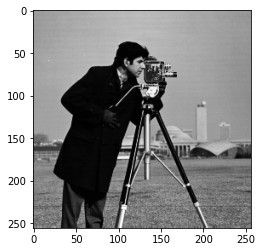

In [ ]:
print(img.shape)

plt.imshow(img, cmap = 'gray')
plt.show()

By printing out the shape, we can see that the image is 512 x 512 pixels and is grayscale. We are going to downsample it to 128 x 128 for easier computation and view it after downsampling. We can also print out the minimum and maximum pixel values.

(64, 64)
8 250


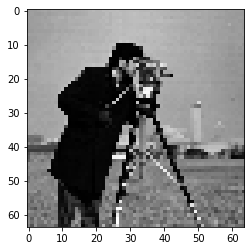

In [ ]:
img = img[::4, ::4]
print(img.shape)

print(np.amin(img), np.amax(img))

plt.imshow(img, cmap='gray')
plt.show()

# Putting It All Together

In [ ]:
generation = 0
best_fitness = []  # going to track the max fitness values in this list
desired_fitness = 0.90  # keep going until the max fitness equals or exceeds 0.9

# initialize population and compute initial fitness values
population = init_population(20, img.size)
fitness_vals = evaluate_fitness(population, img)

while max(fitness_vals) < desired_fitness:
    parents = select(population, fitness_vals)
    children = reproduction(parents)
    children = mutate(children)
    population = make_next_generation(parents, children)
    fitness_vals = evaluate_fitness(population, img)

    # plotting metrics and progress
    if generation % 100 == 0:
        best_fitness.append([generation, max(fitness_vals)])

    if generation % 2000 == 0:
        print('Generation: {}; Max Fitness: {}'.format(generation, max(fitness_vals)))

        max_fitness_indx = [i for i in range(len(fitness_vals)) if fitness_vals[i] == max(fitness_vals)]
        fig = plt.figure()
        sub1, sub2 = fig.add_subplot(121), fig.add_subplot(122)
        sub1.imshow(scale(population[max_fitness_indx].reshape([img.shape[0], img.shape[1]])), cmap='gray')
        sub2.imshow(img, cmap='gray')
        sub1.set_title("Best Image")
        sub2.set_title("Actual Image")
        plt.show()

        plt.bar(x = list(range(len(fitness_vals))), height = sorted(fitness_vals, reverse=True))
        plt.xlabel("Individual")
        plt.ylabel("Fitness Value")
        plt.show()

        plt.plot([x[0] for x in best_fitness], [x[1] for x in best_fitness])
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness Value")
        plt.show()

    generation += 1